<h1>Kaggle Competition</H1>

In this challenge, we will build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

<h3>Reading the data

In [1129]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_classification
import numpy as np
from sklearn.model_selection import GridSearchCV

In [1130]:
train_data_df = pd.read_csv("train.csv")
test_data_df = pd.read_csv("test.csv")
kaggle_prediction_df = pd.read_csv("gender_submission.csv")

In [1131]:
print("Training data set size:", train_data_df.shape)
print("Testing data set size:", test_data_df.shape)

Training data set size: (891, 12)
Testing data set size: (418, 11)


In [1132]:
train_data_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<H3>Data Wrangling

1. Let's identify the missing values from the two sets and deal with them:

    - Age - Impute the mean value
    - Cabin - Impute the most frequent value
    - Embarked (training set only) - Imput the most frequent value
    - Fare (testing set only) - impute the mean value


In [1133]:
train_data_df.isnull().sum()/len(train_data_df)*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [1134]:
test_data_df.isnull().sum()/len(test_data_df)*100

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64

2. Replace the <u>**age**</u> null values with the mean:

In [1135]:
train_data_df.fillna({'Age': train_data_df['Age'].mean()}, inplace=True)
test_data_df.fillna({'Age': test_data_df['Age'].mean()}, inplace=True)

3. Replace the <u>**Cabin**</u> null values with the most frequent:

    (For the training set, wince we have 3 most frequent values, we'll imput randomly using the 3 values)

In [1136]:
import random

# Training Set
modes = train_data_df['Cabin'].mode()  # This might return multiple values
most_frequent = random.choice(modes)  # Randomly selects one of the modes
train_data_df.fillna({'Cabin': most_frequent}, inplace=True)

# Testing Set
most_frequent = test_data_df['Cabin'].mode()[0]  # Selects the first most frequent category
test_data_df.fillna({'Cabin': most_frequent}, inplace=True)

4. Replacing the <u>**Embarked**</u> null values in training set with the most frequent:

In [1137]:
most_frequent = train_data_df['Embarked'].mode()[0]
train_data_df.fillna({'Embarked': most_frequent}, inplace=True)

5. Replacing the <u>**Fare**</u> null values in the test set with the mean:

In [1138]:
test_data_df.fillna({'Fare': test_data_df['Fare'].mean()}, inplace=True)

Now both our training and test sets have no more null values:

In [1139]:
print(train_data_df.isnull().sum()/len(train_data_df)*100)
print(test_data_df.isnull().sum()/len(test_data_df)*100)


PassengerId    0.0
Survived       0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Cabin          0.0
Embarked       0.0
dtype: float64
PassengerId    0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Cabin          0.0
Embarked       0.0
dtype: float64


<h3>Exploratory Data Analysis

In [1140]:
train_data_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,C23 C25 C27,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,C23 C25 C27,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,C23 C25 C27,S
5,6,0,3,"Moran, Mr. James",male,29.699118,0,0,330877,8.4583,C23 C25 C27,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,C23 C25 C27,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,C23 C25 C27,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.0708,C23 C25 C27,C


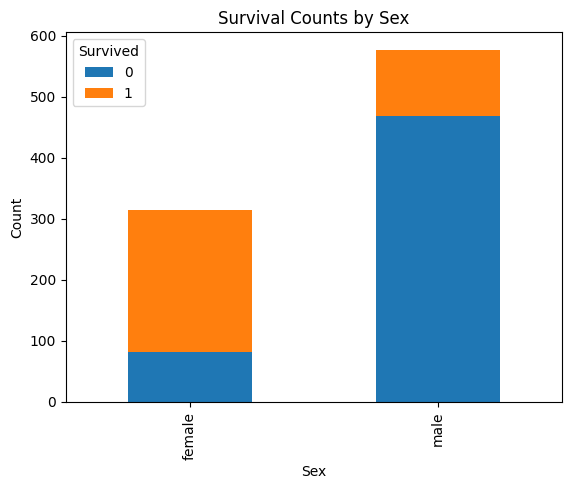

In [1141]:
survival_counts = train_data_df.groupby(['Sex', 'Survived'])['Survived'].count().unstack()
survival_counts.plot(kind='bar', stacked=True)
plt.title('Survival Counts by Sex')
plt.ylabel('Count')
plt.show()

The above plot tells the following:
1. There are more male passengers than females.
2. Most male passengers didn't survived.
3. Most female passengers survided.

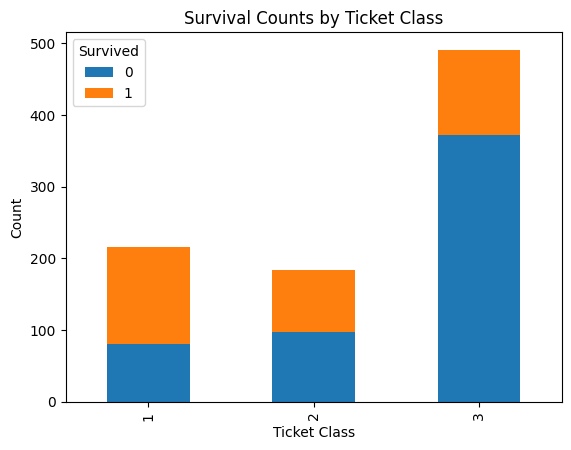

In [1142]:
survival_counts = train_data_df.groupby(['Pclass', 'Survived'])['Survived'].count().unstack()
survival_counts.plot(kind='bar', stacked=True)
plt.title('Survival Counts by Ticket Class')
plt.ylabel('Count')
plt.xlabel('Ticket Class')
plt.show()

Moreover, most who died are from the lower class.

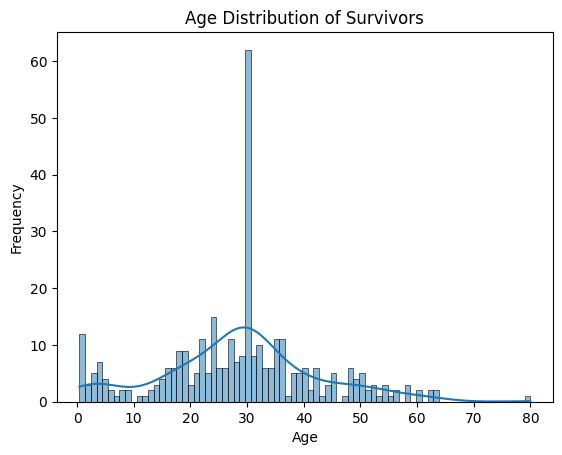

In [1143]:
survivors = train_data_df[train_data_df['Survived']==1]
max_age = survivors['Age'].max()
min_age = survivors['Age'].min()
bins = int(max_age - min_age)


sns.histplot(survivors['Age'], bins=bins, kde=True)
plt.title('Age Distribution of Survivors')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In terms of age distribution, passengers aroung ages 20-40 are more likely to survive.

<h3>Let's convert the necessary categorical variable to binary variables using one-hot encoding.

In [1144]:
train_data_encoded = pd.get_dummies(train_data_df, columns=['Sex', 'Embarked'])
test_data_encoded = pd.get_dummies(test_data_df, columns=['Sex', 'Embarked'])

In [1145]:
train_data_encoded.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,C23 C25 C27,False,True,False,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,True,False,True,False,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,C23 C25 C27,True,False,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,True,False,False,False,True
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,C23 C25 C27,False,True,False,False,True


In [1146]:
train_data_encoded.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Sex_female        bool
Sex_male          bool
Embarked_C        bool
Embarked_Q        bool
Embarked_S        bool
dtype: object

<h3>Feature Selection

1. Let's drop 'object' columns that aren't needed for our model

In [1147]:
train_data_encoded = train_data_encoded.drop(['Name', 'Ticket', 'Cabin'], axis=1)
test_data_encoded = test_data_encoded.drop(['Name', 'Ticket','Cabin'], axis=1)

2. Split the features and the target for the training data set

In [1148]:
X_train = train_data_encoded.drop('Survived', axis=1)
Y_train = train_data_encoded['Survived']

3. Standardize the training data set features <code>X_train</code> then reassign it the same variable.

In [1149]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

4. Standardize the testing data set features <code>X_test</code> then reassign it the same variable.

In [1150]:
scaler.fit(test_data_encoded)
X_test = scaler.transform(test_data_encoded)

5. Assign the target values of the testing data set to <code>Y_test</code>

In [1151]:
Y_test = kaggle_prediction_df['Survived']


<h3>Model Development

1. Defining Model Hyperparameters

In [1152]:
# Hyperparameters for Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

# Hyperparameters for Random Forest
param_grid_rf = {
    'n_estimators': [10, 50, 100],
    'max_depth':
        [None, 10, 20, 30]
}

# Decision Tree Classifier
dt_params = {
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10]
}

# K-Nearest Neighbors Classifier
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

# Support Vector Machine Classifier
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf']
}

2. Using Logistic Regression

In [1153]:
# Initialize the GridSearchCV object for Logistic Regression
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=10, scoring='accuracy')

# Fit it to the training data
grid_search_lr.fit(X_train, Y_train)

# Best parameters and score for Logistic Regression
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best score for Logistic Regression:", grid_search_lr.best_score_)

Best parameters for Logistic Regression: {'C': 0.1, 'solver': 'saga'}
Best score for Logistic Regression: 0.7979900124843944


3. Using Random Forest

In [1154]:
# Initialize the GridSearchCV object for Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=10, scoring='accuracy')
grid_search_rf.fit(X_train, Y_train)

print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best score for Random Forest:", grid_search_rf.best_score_)


Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 100}
Best score for Random Forest: 0.8294382022471909


4. Using Decision Tree

In [1155]:
grid_search_dt = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train, Y_train)

print("Decision Tree best parameters:", grid_search_dt.best_params_)
print("Decision Tree best score:", grid_search_dt.best_score_)

Decision Tree best parameters: {'max_depth': 6, 'min_samples_split': 2}
Decision Tree best score: 0.7891343920657835


5. Using KNN

In [1156]:
grid_search_knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, Y_train)

print("KNN best parameters:", grid_search_knn.best_params_)
print("KNN best score:", grid_search_knn.best_score_)

KNN best parameters: {'n_neighbors': 9, 'weights': 'uniform'}
KNN best score: 0.8092084614901764


6. Using SVM

In [1157]:
grid_search_svm = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train, Y_train)

print("SVM best parameters:", grid_search_svm.best_params_)
print("SVM best score:", grid_search_svm.best_score_)

SVM best parameters: {'C': 1, 'kernel': 'rbf'}
SVM best score: 0.8237963718536188


<H3>Evaluating the Models using the Test Data

In [1158]:
lr_test_score = grid_search_lr.best_estimator_.score(X_test, Y_test)
rf_test_score = grid_search_rf.best_estimator_.score(X_test, Y_test)
dt_test_score = grid_search_dt.best_estimator_.score(X_test, Y_test)
knn_test_score = grid_search_knn.best_estimator_.score(X_test, Y_test)
svm_test_score = grid_search_svm.best_estimator_.score(X_test, Y_test)

In [1159]:
accuracy_arr = {
    'Logistic Regression': lr_test_score,
    'Random Forest': rf_test_score,
    'Decision Tree': dt_test_score,
    'KNN': knn_test_score,
    'SVM': svm_test_score
}
accuracy_df = pd.DataFrame(list(accuracy_arr.items()), columns=['Model', 'Accuracy'])
accuracy_df

,Model,Accuracy
0,Logistic Regression,0.942584
1,Random Forest,0.897129
2,Decision Tree,0.851675
3,KNN,0.885167
4,SVM,0.918660


The best Classification model to use is Logistic Regression

<H3>Predicting the Test Data Set

1. Predict the Standardized data set using Logistic Regression model utilizing Grid Search:

In [1160]:
yhat_test_lr = grid_search_lr.best_estimator_.predict(X_test)

In [1161]:
my_prediction_df = test_data_encoded[['PassengerId']].copy()
my_prediction_df ['Survived'] = yhat_test_lr

In [1162]:
my_prediction_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


2. Saving the prediction to a CSV file:

In [1163]:
my_prediction_df.to_csv("submission.csv", index=False)

<H3>Comparing My Prediction with Kaggel's and see how much they differ

In [1164]:
# Perform an element-wise comparison
comparison = my_prediction_df == kaggle_prediction_df
difference_percentage = (np.invert(comparison).mean().mean()) * 100

In [1165]:
print(f"Prediction differ by {difference_percentage:.2f}%")

Prediction differ by 2.87%
